In [3]:
import os
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [4]:
# Read dataset to a dataframe
df = pd.read_csv('pivot.csv',encoding='windows-1254')

df.head()

,Unnamed: 0,YEAR-MONTH,COASTAL KARNATAKA,KERALA,RAYALSEEMA,SOUTH INTERIOR KARNATAKA,TAMIL NADU
0,0,1901-APR,52.4,160.0,12.1,32.7,36.0
1,1,1901-AUG,606.4,357.5,60.3,109.2,67.9
2,2,1901-DEC,17.8,48.4,91.3,12.3,80.4
3,3,1901-FEB,0.6,44.7,50.2,31.8,39.1
4,4,1901-JAN,1.8,28.7,7.0,4.9,24.5


In [5]:
# Drop the unnecessary index column
df.drop(columns=['Unnamed: 0'], inplace=True)

# Extract year and month from the 'YEAR-MONTH' column
df['YEAR'] = df['YEAR-MONTH'].apply(lambda x: int(x.split('-')[0]))
df['MONTH'] = df['YEAR-MONTH'].apply(lambda x: x.split('-')[1])

# Drop the original 'YEAR-MONTH' column
df.drop(columns=['YEAR-MONTH'], inplace=True)

# Check for missing values in the 'SOUTH INTERIOR KARNATAKA' column
missing_values_count = df['SOUTH INTERIOR KARNATAKA'].isnull().sum()

# Show the first few rows after preprocessing and the number of missing values
df.head(), missing_values_count


(   COASTAL KARNATAKA  KERALA  RAYALSEEMA  SOUTH INTERIOR KARNATAKA  \
 0               52.4   160.0        12.1                      32.7   
 1              606.4   357.5        60.3                     109.2   
 2               17.8    48.4        91.3                      12.3   
 3                0.6    44.7        50.2                      31.8   
 4                1.8    28.7         7.0                       4.9   
 
    TAMIL NADU  YEAR MONTH  
 0        36.0  1901   APR  
 1        67.9  1901   AUG  
 2        80.4  1901   DEC  
 3        39.1  1901   FEB  
 4        24.5  1901   JAN  ,
 0)

In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode the 'MONTH' column
label_encoder = LabelEncoder()
df['MONTH_ENCODED'] = label_encoder.fit_transform(df['MONTH'])

# Select features and target variable
features = ['YEAR', 'MONTH_ENCODED']
target = 'SOUTH INTERIOR KARNATAKA'

# Show the first few rows after feature engineering
df.head()


,COASTAL KARNATAKA,KERALA,RAYALSEEMA,SOUTH INTERIOR KARNATAKA,TAMIL NADU,YEAR,MONTH,MONTH_ENCODED
0,52.4,160.0,12.1,32.7,36.0,1901,APR,0
1,606.4,357.5,60.3,109.2,67.9,1901,AUG,1
2,17.8,48.4,91.3,12.3,80.4,1901,DEC,2
3,0.6,44.7,50.2,31.8,39.1,1901,FEB,3
4,1.8,28.7,7.0,4.9,24.5,1901,JAN,4


In [7]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80% training, 20% testing)
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Show the size of the training and test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1104, 2), (276, 2), (1104,), (276,))

In [17]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize and train a simpler XGBoost model with fewer estimators
xgb_model_simple = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=200, random_state=42)
xgb_model_simple.fit(X_train, y_train)

# Make predictions on the test set
y_pred_simple = xgb_model_simple.predict(X_test)

# Evaluate the simpler model
mse_simple = mean_squared_error(y_test, y_pred_simple)
rmse_simple = mse_simple ** 0.5
mae_simple = mean_absolute_error(y_test, y_pred_simple)
r2_simple = r2_score(y_test, y_pred_simple)

mse_simple, rmse_simple, mae_simple, r2_simple



(2844.65942705611, 53.33534875723707, 39.24256815521614, 0.5577756432293186)

In [18]:
# Sample data for predictions: [Year, Encoded Month]
# Let's assume we want to predict rainfall for the year 2025 for January, April, July, and October
# Encoded months: January=4, April=0, July=5, October=8
sample_data = [[2025, 4], [2025, 0], [2025, 5], [2025, 8]]

# Make predictions using the trained XGBoost model
# sample_predictions = xgb_model_simple.predict(sample_data)

# Display the sample predictions
sample_predictions


array([-19.743225,  79.32191 , 114.20989 , 127.881935], dtype=float32)

In [19]:
import numpy as np

# Convert sample data to NumPy array
sample_data_np = np.array(sample_data)

# Make predictions using the trained XGBoost model
sample_predictions = xgb_model_simple.predict(sample_data_np)

# Display the sample predictions
sample_predictions


array([-19.743225,  79.32191 , 114.20989 , 127.881935], dtype=float32)

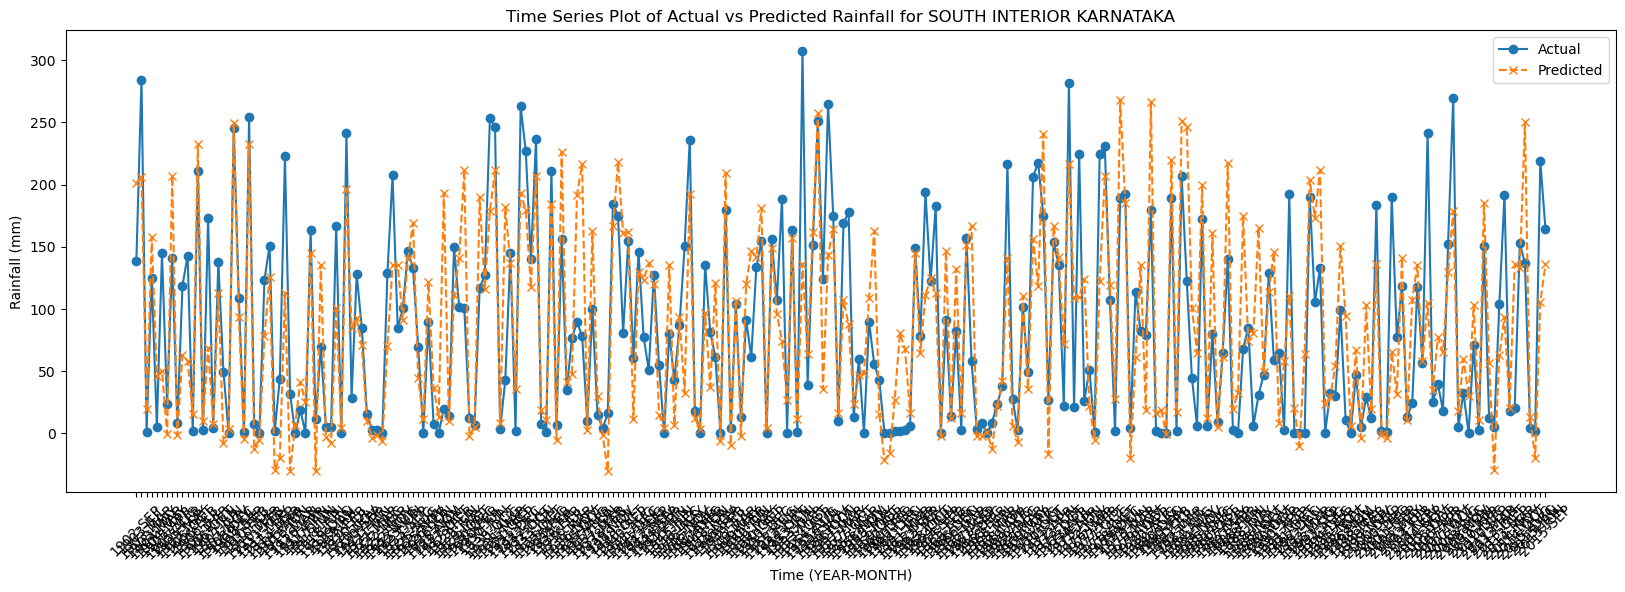

In [20]:
# Create a DataFrame to hold the test data and predictions
result_df = pd.DataFrame({'YEAR': X_test['YEAR'], 'MONTH_ENCODED': X_test['MONTH_ENCODED'], 'Actual': y_test, 'Predicted': y_pred_simple})
result_df['MONTH'] = label_encoder.inverse_transform(result_df['MONTH_ENCODED'])

# Sort the DataFrame by YEAR and MONTH_ENCODED for plotting
result_df.sort_values(by=['YEAR', 'MONTH_ENCODED'], inplace=True)

# Create a time series plot
plt.figure(figsize=(20, 6))
plt.plot(result_df['YEAR'].astype(str) + '-' + result_df['MONTH'], result_df['Actual'], label='Actual', marker='o', linestyle='-')
plt.plot(result_df['YEAR'].astype(str) + '-' + result_df['MONTH'], result_df['Predicted'], label='Predicted', marker='x', linestyle='--')
plt.title('Time Series Plot of Actual vs Predicted Rainfall for SOUTH INTERIOR KARNATAKA')
plt.xlabel('Time (YEAR-MONTH)')
plt.ylabel('Rainfall (mm)')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [25]:
df.isnull().sum()

COASTAL KARNATAKA           1
KERALA                      0
RAYALSEEMA                  0
SOUTH INTERIOR KARNATAKA    0
TAMIL NADU                  0
dtype: int64

In [26]:
df.dropna(inplace=True)

In [27]:
# cols = ['Gender', 'Education',
#        'Job ( clerical/forces  /agriculture/ labor/retired/ other)',
#        'Source of water for drinking(tube well/public well/private well/pipe bourn)',
#        'Smorking or not', 'Using alcohol or not', 'Using betel nut or not',
#        'Do you have any of this disorders diabetes/stress/blood pressure ', 'Having kidney disease']
# df[cols] = df[cols].apply(LabelEncoder().fit_transform)
# df.head()
df

,COASTAL KARNATAKA,KERALA,RAYALSEEMA,SOUTH INTERIOR KARNATAKA,TAMIL NADU
0,52.4,160.0,12.1,32.7,36.0
1,606.4,357.5,60.3,109.2,67.9
2,17.8,48.4,91.3,12.3,80.4
3,0.6,44.7,50.2,31.8,39.1
4,1.8,28.7,7.0,4.9,24.5
...,...,...,...,...,...
1375,32.3,50.1,13.4,24.4,21.7
1376,150.3,201.8,39.7,125.3,112.4
1377,124.2,223.6,383.8,138.1,379.8
1378,208.5,308.1,106.7,106.1,132.6


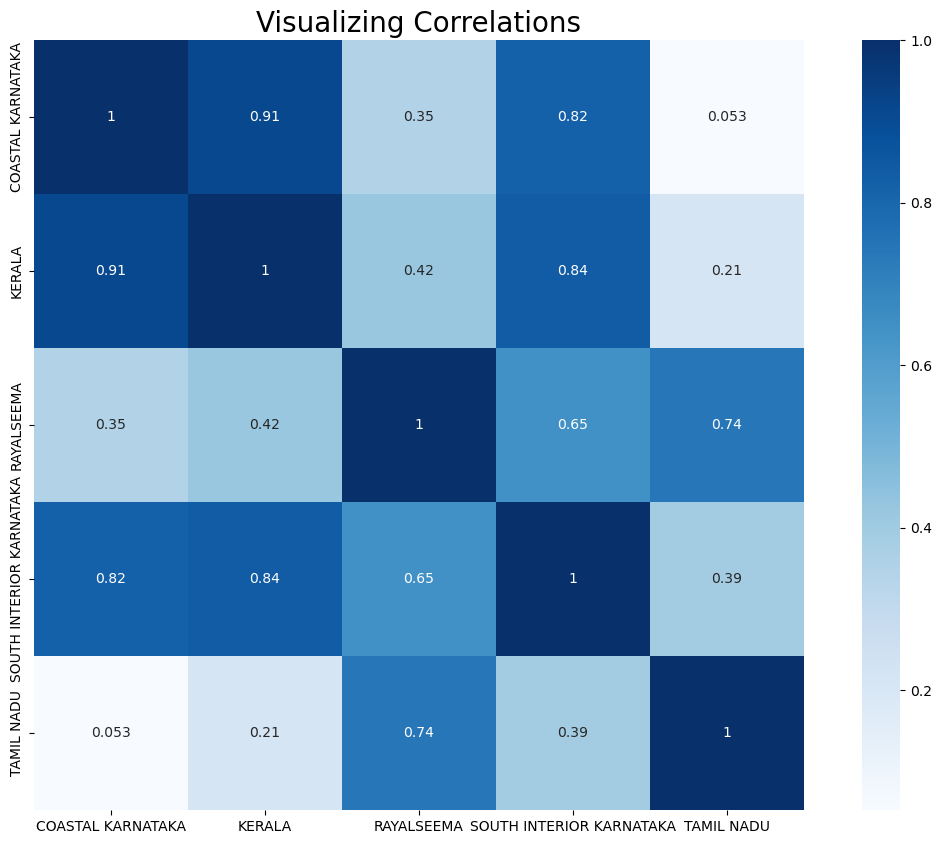

In [28]:
plt.figure(figsize = (15, 10))
sns.heatmap(df.corr(), cmap = 'Blues', square = True, annot = True)
plt.title("Visualizing Correlations", size = 20)
plt.show()

In [29]:
# sns.pairplot(df,hue='Having kidney disease')

In [30]:
# columns=df.columns
# columns=list(columns)
# columns.pop()

# sns.set(rc={'figure.figsize':(15,17)})
# sns.set_style(style='white')

# for i in range(len(columns)):
#     plt.subplot(4,3,i+1)
#     sns.distplot(df[columns[i]], hist=True, rug=True, color='b')

In [31]:
df.columns

Index(['COASTAL KARNATAKA', 'KERALA', 'RAYALSEEMA', 'SOUTH INTERIOR KARNATAKA',
       'TAMIL NADU'],
      dtype='object')

In [32]:
x = df[['COASTAL KARNATAKA', 'KERALA', 'RAYALSEEMA',
       'TAMIL NADU']].values


y = df['SOUTH INTERIOR KARNATAKA'].values

In [33]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=100,test_size=0.25)

In [34]:
x_train.shape
y_train.shape

(1034,)

In [35]:
import xgboost as xgb

In [36]:
xgbc = xgb.XGBClassifier() 

In [37]:
xgbc.fit(x_train, y_train)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431
 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449
 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467
 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503
 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521
 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539
 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557
 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575
 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703 704 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719
 720 721 722 723 724 725 726], got [0.000e+00 1.000e-01 2.000e-01 3.000e-01 4.000e-01 5.000e-01 6.000e-01
 7.000e-01 8.000e-01 9.000e-01 1.000e+00 1.100e+00 1.200e+00 1.300e+00
 1.400e+00 1.500e+00 1.700e+00 1.800e+00 1.900e+00 2.000e+00 2.100e+00
 2.200e+00 2.300e+00 2.400e+00 2.500e+00 2.600e+00 2.700e+00 2.800e+00
 2.900e+00 3.000e+00 3.100e+00 3.200e+00 3.400e+00 3.500e+00 3.600e+00
 3.800e+00 3.900e+00 4.000e+00 4.100e+00 4.200e+00 4.300e+00 4.400e+00
 4.500e+00 4.600e+00 4.700e+00 4.800e+00 4.900e+00 5.000e+00 5.200e+00
 5.300e+00 5.400e+00 5.500e+00 5.700e+00 5.800e+00 5.900e+00 6.200e+00
 6.300e+00 6.500e+00 6.600e+00 6.700e+00 6.800e+00 6.900e+00 7.100e+00
 7.200e+00 7.300e+00 7.400e+00 7.500e+00 7.600e+00 7.900e+00 8.000e+00
 8.100e+00 8.300e+00 8.400e+00 8.700e+00 8.900e+00 9.000e+00 9.100e+00
 9.200e+00 9.400e+00 9.600e+00 9.700e+00 9.800e+00 1.000e+01 1.030e+01
 1.040e+01 1.050e+01 1.070e+01 1.090e+01 1.110e+01 1.120e+01 1.140e+01
 1.150e+01 1.160e+01 1.170e+01 1.190e+01 1.210e+01 1.230e+01 1.240e+01
 1.250e+01 1.270e+01 1.280e+01 1.300e+01 1.310e+01 1.330e+01 1.370e+01
 1.380e+01 1.390e+01 1.410e+01 1.420e+01 1.430e+01 1.460e+01 1.480e+01
 1.520e+01 1.550e+01 1.570e+01 1.580e+01 1.590e+01 1.600e+01 1.640e+01
 1.740e+01 1.760e+01 1.770e+01 1.810e+01 1.830e+01 1.840e+01 1.860e+01
 1.920e+01 1.940e+01 1.950e+01 1.960e+01 1.980e+01 1.990e+01 2.010e+01
 2.060e+01 2.090e+01 2.110e+01 2.170e+01 2.180e+01 2.230e+01 2.240e+01
 2.300e+01 2.340e+01 2.370e+01 2.390e+01 2.400e+01 2.410e+01 2.440e+01
 2.460e+01 2.470e+01 2.480e+01 2.490e+01 2.500e+01 2.540e+01 2.550e+01
 2.570e+01 2.580e+01 2.600e+01 2.620e+01 2.630e+01 2.650e+01 2.670e+01
 2.690e+01 2.700e+01 2.720e+01 2.770e+01 2.840e+01 2.860e+01 2.880e+01
 2.890e+01 2.930e+01 3.010e+01 3.040e+01 3.060e+01 3.080e+01 3.130e+01
 3.160e+01 3.180e+01 3.190e+01 3.210e+01 3.230e+01 3.270e+01 3.280e+01
 3.310e+01 3.330e+01 3.360e+01 3.370e+01 3.440e+01 3.450e+01 3.470e+01
 3.540e+01 3.580e+01 3.640e+01 3.700e+01 3.750e+01 3.780e+01 3.790e+01
 3.850e+01 3.870e+01 3.890e+01 3.900e+01 3.980e+01 4.000e+01 4.010e+01
 4.070e+01 4.090e+01 4.150e+01 4.170e+01 4.200e+01 4.210e+01 4.220e+01
 4.240e+01 4.290e+01 4.310e+01 4.340e+01 4.350e+01 4.380e+01 4.390e+01
 4.430e+01 4.440e+01 4.460e+01 4.470e+01 4.500e+01 4.560e+01 4.570e+01
 4.580e+01 4.610e+01 4.650e+01 4.660e+01 4.700e+01 4.720e+01 4.750e+01
 4.820e+01 4.830e+01 4.870e+01 4.900e+01 4.950e+01 4.960e+01 4.980e+01
 5.080e+01 5.100e+01 5.120e+01 5.140e+01 5.160e+01 5.170e+01 5.260e+01
 5.280e+01 5.340e+01 5.460e+01 5.490e+01 5.500e+01 5.540e+01 5.570e+01
 5.670e+01 5.690e+01 5.760e+01 5.780e+01 5.840e+01 5.860e+01 5.900e+01
 5.930e+01 5.960e+01 6.000e+01 6.010e+01 6.020e+01 6.090e+01 6.110e+01
 6.130e+01 6.170e+01 6.220e+01 6.250e+01 6.260e+01 6.330e+01 6.400e+01
 6.410e+01 6.420e+01 6.530e+01 6.590e+01 6.610e+01 6.670e+01 6.690e+01
 6.740e+01 6.750e+01 6.800e+01 6.850e+01 6.940e+01 6.960e+01 7.010e+01
 7.050e+01 7.070e+01 7.090e+01 7.100e+01 7.140e+01 7.160e+01 7.240e+01
 7.250e+01 7.260e+01 7.320e+01 7.380e+01 7.470e+01 7.490e+01 7.540e+01
 7.630e+01 7.650e+01 7.670e+01 7.680e+01 7.700e+01 7.710e+01 7.750e+01
 7.780e+01 7.790e+01 7.800e+01 7.810e+01 7.840e+01 7.890e+01 7.960e+01
 7.990e+01 8.020e+01 8.050e+01 8.100e+01 8.130e+01 8.140e+01 8.150e+01
 8.160e+01 8.180e+01 8.190e+01 8.210e+01 8.230e+01 8.240e+01 8.260e+01
 8.350e+01 8.400e+01 8.430e+01 8.460e+01 8.470e+01 8.490e+01 8.520e+01
 8.550e+01 8.690e+01 8.800e+01 8.840e+01 8.850e+01 8.880e+01 8.890e+01
 8.950e+01 8.960e+01 8.970e+01 8.980e+01 9.060e+01 9.080e+01 9.090e+01
 9.100e+01 9.120e+01 9.170e+01 9.210e+01 9.220e+01 9.260e+01 9.300e+01
 9.340e+01 9.490e+01 9.560e+01 9.600e+01 9.620e+01 9.640e+01 9.760e+01
 9.770e+01 9.780e+01 9.800e+01 9.850e+01 9.870e+01 9.900e+01 9.930e+01
 9.980e+01 1.000e+02 1.005e+02 1.006e+02 1.009e+02 1.013e+02 1.015e+02
 1.016e+02 1.019e+02 1.021e+02 1.024e+02 1.027e+02 1.037e+02 1.044e+02
 1.045e+02 1.052e+02 1.053e+02 1.060e+02 1.061e+02 1.065e+02 1.068e+02
 1.071e+02 1.078e+02 1.079e+02 1.080e+02 1.084e+02 1.085e+02 1.086e+02
 1.087e+02 1.089e+02 1.090e+02 1.092e+02 1.095e+02 1.096e+02 1.099e+02
 1.101e+02 1.112e+02 1.116e+02 1.120e+02 1.128e+02 1.129e+02 1.130e+02
 1.135e+02 1.139e+02 1.143e+02 1.149e+02 1.151e+02 1.153e+02 1.158e+02
 1.165e+02 1.168e+02 1.171e+02 1.175e+02 1.177e+02 1.180e+02 1.181e+02
 1.182e+02 1.185e+02 1.201e+02 1.204e+02 1.215e+02 1.217e+02 1.219e+02
 1.222e+02 1.223e+02 1.224e+02 1.227e+02 1.231e+02 1.232e+02 1.235e+02
 1.238e+02 1.245e+02 1.249e+02 1.251e+02 1.253e+02 1.257e+02 1.269e+02
 1.272e+02 1.281e+02 1.285e+02 1.290e+02 1.291e+02 1.295e+02 1.296e+02
 1.298e+02 1.301e+02 1.305e+02 1.312e+02 1.319e+02 1.326e+02 1.328e+02
 1.329e+02 1.330e+02 1.336e+02 1.337e+02 1.344e+02 1.345e+02 1.350e+02
 1.351e+02 1.352e+02 1.356e+02 1.357e+02 1.359e+02 1.363e+02 1.366e+02
 1.368e+02 1.371e+02 1.374e+02 1.375e+02 1.381e+02 1.382e+02 1.383e+02
 1.387e+02 1.388e+02 1.389e+02 1.393e+02 1.397e+02 1.399e+02 1.405e+02
 1.406e+02 1.408e+02 1.411e+02 1.414e+02 1.423e+02 1.428e+02 1.432e+02
 1.446e+02 1.447e+02 1.448e+02 1.450e+02 1.455e+02 1.465e+02 1.468e+02
 1.470e+02 1.472e+02 1.483e+02 1.484e+02 1.485e+02 1.487e+02 1.489e+02
 1.490e+02 1.491e+02 1.494e+02 1.497e+02 1.498e+02 1.503e+02 1.505e+02
 1.507e+02 1.510e+02 1.516e+02 1.518e+02 1.520e+02 1.522e+02 1.525e+02
 1.532e+02 1.538e+02 1.539e+02 1.542e+02 1.545e+02 1.549e+02 1.551e+02
 1.556e+02 1.557e+02 1.562e+02 1.567e+02 1.573e+02 1.600e+02 1.616e+02
 1.617e+02 1.618e+02 1.627e+02 1.632e+02 1.641e+02 1.654e+02 1.655e+02
 1.667e+02 1.671e+02 1.675e+02 1.679e+02 1.681e+02 1.682e+02 1.683e+02
 1.684e+02 1.685e+02 1.701e+02 1.712e+02 1.722e+02 1.723e+02 1.729e+02
 1.734e+02 1.735e+02 1.742e+02 1.748e+02 1.749e+02 1.751e+02 1.753e+02
 1.760e+02 1.762e+02 1.771e+02 1.779e+02 1.787e+02 1.789e+02 1.795e+02
 1.796e+02 1.798e+02 1.802e+02 1.813e+02 1.835e+02 1.840e+02 1.849e+02
 1.850e+02 1.852e+02 1.859e+02 1.863e+02 1.865e+02 1.866e+02 1.868e+02
 1.874e+02 1.881e+02 1.883e+02 1.885e+02 1.886e+02 1.887e+02 1.891e+02
 1.893e+02 1.894e+02 1.899e+02 1.905e+02 1.915e+02 1.916e+02 1.917e+02
 1.918e+02 1.925e+02 1.928e+02 1.933e+02 1.938e+02 1.951e+02 1.962e+02
 1.966e+02 1.971e+02 1.975e+02 1.981e+02 1.992e+02 1.995e+02 2.005e+02
 2.012e+02 2.024e+02 2.034e+02 2.037e+02 2.044e+02 2.045e+02 2.047e+02
 2.055e+02 2.057e+02 2.062e+02 2.064e+02 2.066e+02 2.077e+02 2.079e+02
 2.082e+02 2.096e+02 2.097e+02 2.100e+02 2.101e+02 2.110e+02 2.111e+02
 2.113e+02 2.149e+02 2.153e+02 2.159e+02 2.163e+02 2.167e+02 2.168e+02
 2.170e+02 2.176e+02 2.178e+02 2.194e+02 2.213e+02 2.240e+02 2.246e+02
 2.248e+02 2.250e+02 2.257e+02 2.266e+02 2.267e+02 2.280e+02 2.281e+02
 2.297e+02 2.315e+02 2.325e+02 2.326e+02 2.327e+02 2.332e+02 2.343e+02
 2.345e+02 2.350e+02 2.362e+02 2.365e+02 2.366e+02 2.376e+02 2.386e+02
 2.389e+02 2.408e+02 2.412e+02 2.416e+02 2.426e+02 2.431e+02 2.452e+02
 2.468e+02 2.475e+02 2.479e+02 2.484e+02 2.489e+02 2.491e+02 2.513e+02
 2.517e+02 2.528e+02 2.539e+02 2.541e+02 2.543e+02 2.546e+02 2.556e+02
 2.559e+02 2.563e+02 2.575e+02 2.609e+02 2.619e+02 2.625e+02 2.629e+02
 2.636e+02 2.643e+02 2.650e+02 2.688e+02 2.698e+02 2.719e+02 2.756e+02
 2.760e+02 2.800e+02 2.818e+02 2.830e+02 2.841e+02 2.863e+02 2.877e+02
 2.896e+02 2.985e+02 2.998e+02 3.054e+02 3.074e+02 3.097e+02 3.104e+02
 3.247e+02 3.335e+02 3.364e+02 3.504e+02 3.685e+02 4.609e+02]

In [ ]:
score = xgbc.score(x_test, y_test)  
print("Training score: ", score)

In [ ]:
y_pred = xgbc.predict(x_test)
y_pred

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,y_pred)

In [ ]:
np.sqrt(mean_squared_error(y_test,y_pred))

In [ ]:
# visualize confusion matrix with seaborn heatmap
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu',square=True, ax=ax, annot_kws={"fontsize":16})

In [ ]:
xgb.plot_importance(xgbc.fit(x_train,y_train))

# Feature Importance refers to techniques that calculate a score for all the input features for a given model — the scores simply represent the “importance” of each feature. A higher score means that the specific feature will have a larger effect on the model that is being used to predict a certain variable.

In [ ]:
df.head()

In [ ]:
xgbc.predict([[46,0,13,2,70000,2,2,1,1]])

In [ ]:
import pickle
pickle.dump(clf, open('model.pkl','wb'))

In [ ]:
model = pickle.load(open('model.pkl','rb'))
print(clf.predict([[1,1,1,1,1,1,1,1,1]]))